<a href="https://colab.research.google.com/github/divinit7/Music_genre_classification/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !mkdir genres && wget http://opihi.cs.uvic.ca/sound/genres.tar.gz && tar -xf genres.tar.gz genres/

In [2]:
# pip install torchaudio
# !pip install torch===1.7.1 torchvision===0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [3]:
# !pip install --upgrade pip
# !pip cache purge

In [4]:
import torch
import torchvision 
import torchaudio
import random
import librosa.display
import pandas as pd
import numpy as np
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from tqdm.notebook import tqdm
import IPython.display as display
import torchvision.transforms as T

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [5]:
# data_path = '/content/genres/'
# cmap = plt.get_cmap('inferno')
# plt.figure(figsize=(8, 8))
# genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
# for g in genres:
#   pathlib.Path(f'img_data/{g}').mkdir(parents = True, exist_ok = True)
#   for filename in os.listdir(f'{data_path}/{g}'):
#     songname = f'{data_path}/{g}/{filename}'
#     y, sr = librosa.load(songname, mono = True, duration = 5)
#     plt.specgram(y, NFFT = 2048, Fs=2, Fc=0, noverlap = 128, cmap = cmap,sides = 'default', mode = 'default', scale = 'dB')
#     plt.axis('off')
#     plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
#     plt.clf()

In [6]:
img_path = 'img_data'
batch_size = 8
image_size = 224

train_trfms = T.Compose([
                         T.Resize(image_size),
                         T.RandomRotation(20),
                         T.RandomHorizontalFlip(),
                         T.ToTensor()
])

val_trfms = T.Compose([
                       T.Resize(image_size),
                       T.ToTensor()
])

In [7]:
# !pip uninstall torchvision -y
# !pip uninstall torch -y
# !pip uninstall torchaudio -y

In [8]:
train_data = torchvision.datasets.ImageFolder(root = img_path,transform =  train_trfms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trfms)

In [9]:
def Encode(data):
  classes = data.classes
  encoder = {}
  for i in range(len(classes)):
    encoder[i] = classes[i]
  return encoder

def Decoder(data):
  classes = data.classes

  decoder = {}
  for i in range(len(classes)):
    decoder[classes[i]] = i
  return decoder

In [10]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
#         print(type(image))
        label = int(label)
        encoder = Encode(data)
        l = encoder[label]
       
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

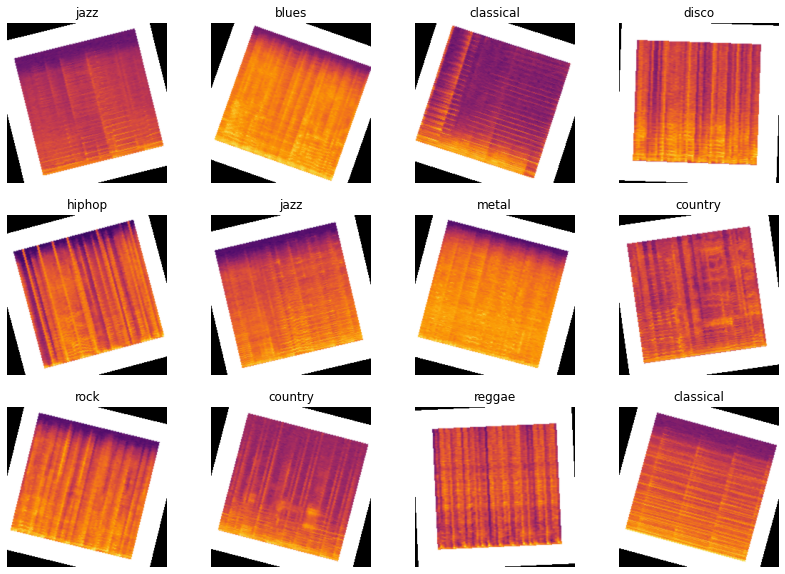

In [11]:
class_plot(train_data)

In [12]:
torch.manual_seed(44)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [13]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(900, 100)

In [14]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True,  num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

image.shape torch.Size([8, 3, 224, 224])


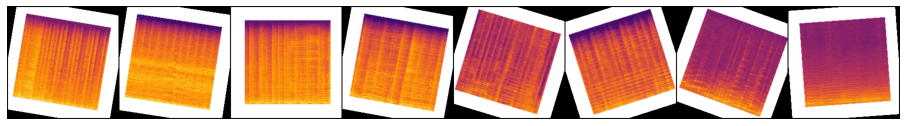

In [15]:
for images, _ in train_dl:
  print(f'image.shape {images.shape}')
  plt.figure(figsize=(16, 8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 15).permute(1, 2, 0))
  break

In [16]:
def accuracy(outputs, labels):
  _,  preds = torch.max(outputs, dim =1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [81]:
class MultilabelImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, targets = batch
    out = self(images)
    loss = F.cross_entropy(out, targets)
    return loss
  
  def validation_step(self, batch):
    images, targets = batch
    out = self(images)
    loss = F.cross_entropy(out, targets)
    score = accuracy(out, targets)
    return {'val_loss': loss.detach(), 'val_score': score.detach()}
  def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
  def epoch_end(self, epoch, result):
       print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

In [82]:
class Net1(MultilabelImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),

    nn.Flatten(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    )
  
  def forward(self, xb):
    return self.network(xb)

In [83]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = models.resnet34(pretrained = True)
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 10)

  def forward(self, xb):
    return self.network(xb)

  def freeze(self):
    for param in self.network.parameters():
      param.require_grad = False
    for param in self.network.fc.parameters():
      param.require_grad = True
  
  def unfreeze(self):
    for param in self.network.parameters():
      param.require_grad = True


In [84]:
Net()

Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [85]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [125]:
@torch.no_grad()
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay = 0, grad_clip=None, opt_func= torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []
  optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
  for epoch in range(epochs):
    model.train()
    lrs = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      loss.backward()
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      optimizer.step()
      optimizer.zero_grad()
      lrs.append(get_lr(optimizer))
      sched.step()
    result = evaluate(model, val_loader)
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [126]:
device = torch.device('cuda')

def to_device(data):
  if isinstance(data, (list, tuple)):
    return [to_device(x) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  def __init__(self, dl):
    self.dl = dl
  
  def __iter__(self):
    for b in self.dl:
      yield to_device(b)

  def __len__(self):
    return len(self.dl)

In [127]:
device

device(type='cuda')

In [128]:
train_dl = DeviceDataLoader(train_dl)
val_dl = DeviceDataLoader(val_dl)

In [129]:
model = to_device(Net())

In [130]:
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1710-9-2-local_9.2.88-1_amd64
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/patches/1/cuda-repo-ubuntu1710-9-2-local-cublas-update-1_1.0-1_amd64

In [131]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [132]:
# pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [133]:
torch.cuda.empty_cache()

In [134]:
history = [evaluate(model, val_dl)]

In [135]:
model.freeze()

In [136]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [137]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip = grad_clip,
                         weight_decay= weight_decay,
                         opt_func = opt_func)


Epoch [0], val_loss: 2.6338, val_score: 0.1607



Epoch [1], val_loss: 2.2036, val_score: 0.2679



Epoch [2], val_loss: 1.8228, val_score: 0.3929



Epoch [3], val_loss: 1.4220, val_score: 0.4821



Epoch [4], val_loss: 1.4210, val_score: 0.4643
CPU times: user 1min 8s, sys: 11.3 s, total: 1min 19s
Wall time: 1min 53s


In [141]:
%%time
history += fit_one_cycle(15, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 1.3730, val_score: 0.5268



Epoch [1], val_loss: 1.6863, val_score: 0.3661



Epoch [2], val_loss: 1.5778, val_score: 0.4643



Epoch [3], val_loss: 1.6113, val_score: 0.4196



Epoch [4], val_loss: 1.8095, val_score: 0.3661



Epoch [5], val_loss: 1.8992, val_score: 0.3125



Epoch [6], val_loss: 1.5034, val_score: 0.5000



Epoch [7], val_loss: 1.4579, val_score: 0.4464



Epoch [8], val_loss: 1.4126, val_score: 0.4821



Epoch [9], val_loss: 1.3861, val_score: 0.4643



Epoch [10], val_loss: 1.1975, val_score: 0.5804



Epoch [11], val_loss: 1.2329, val_score: 0.5357



Epoch [12], val_loss: 1.3326, val_score: 0.5536



Epoch [13], val_loss: 1.2942, val_score: 0.5446



Epoch [14], val_loss: 1.2969, val_score: 0.5804
CPU times: user 3min 28s, sys: 38.3 s, total: 4min 6s
Wall time: 5min 39s


In [142]:
model.unfreeze()

In [143]:
%%time
history += fit_one_cycle(50, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 1.2665, val_score: 0.6250



Epoch [1], val_loss: 1.3327, val_score: 0.5714



Epoch [2], val_loss: 1.1925, val_score: 0.6607



Epoch [3], val_loss: 1.4893, val_score: 0.5893



Epoch [4], val_loss: 1.6118, val_score: 0.5268



Epoch [5], val_loss: 1.4973, val_score: 0.5089



Epoch [6], val_loss: 1.5108, val_score: 0.5446



Epoch [7], val_loss: 1.7015, val_score: 0.4911



Epoch [8], val_loss: 1.4444, val_score: 0.5446



Epoch [9], val_loss: 1.5968, val_score: 0.5089



Epoch [10], val_loss: 1.4086, val_score: 0.5625



Epoch [11], val_loss: 1.7128, val_score: 0.4554



Epoch [12], val_loss: 1.3675, val_score: 0.5625



Epoch [13], val_loss: 1.7491, val_score: 0.5089



Epoch [14], val_loss: 1.1748, val_score: 0.6429



Epoch [15], val_loss: 1.6147, val_score: 0.4821



Epoch [16], val_loss: 1.5731, val_score: 0.5893



Epoch [17], val_loss: 1.3187, val_score: 0.6250



Epoch [18], val_loss: 1.1289, val_score: 0.6696



Epoch [19], val_loss: 1.1646, val_score: 0.6518



Epoch [20], val_loss: 1.1979, val_score: 0.5893



Epoch [21], val_loss: 1.4271, val_score: 0.5446



Epoch [22], val_loss: 1.5964, val_score: 0.5268



Epoch [23], val_loss: 1.2896, val_score: 0.6250



Epoch [24], val_loss: 1.4267, val_score: 0.6518



Epoch [25], val_loss: 1.4728, val_score: 0.5179



Epoch [26], val_loss: 1.8604, val_score: 0.5268



Epoch [27], val_loss: 1.7025, val_score: 0.5625



Epoch [28], val_loss: 1.4502, val_score: 0.6161



Epoch [29], val_loss: 1.2952, val_score: 0.6161



Epoch [30], val_loss: 1.8836, val_score: 0.5804



Epoch [31], val_loss: 1.4084, val_score: 0.6786



Epoch [32], val_loss: 1.5442, val_score: 0.6518



Epoch [33], val_loss: 1.3755, val_score: 0.6161



Epoch [34], val_loss: 1.5232, val_score: 0.6786



Epoch [35], val_loss: 1.5353, val_score: 0.6696



Epoch [36], val_loss: 1.6198, val_score: 0.6607



Epoch [37], val_loss: 1.6099, val_score: 0.6161



Epoch [38], val_loss: 1.6657, val_score: 0.6071



Epoch [39], val_loss: 1.8769, val_score: 0.6250



Epoch [40], val_loss: 1.8186, val_score: 0.6071



Epoch [41], val_loss: 1.7712, val_score: 0.6339



Epoch [42], val_loss: 1.6724, val_score: 0.6518



Epoch [43], val_loss: 1.7813, val_score: 0.7054



Epoch [44], val_loss: 1.8419, val_score: 0.6161



Epoch [45], val_loss: 1.6136, val_score: 0.6161



Epoch [46], val_loss: 1.6031, val_score: 0.6607



Epoch [47], val_loss: 1.7888, val_score: 0.6429



Epoch [48], val_loss: 1.7073, val_score: 0.6429



Epoch [49], val_loss: 1.6318, val_score: 0.6696
CPU times: user 11min 29s, sys: 2min 2s, total: 13min 31s
Wall time: 18min 49s


In [145]:
%%time
history += fit_one_cycle(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 2.0791, val_score: 0.6607



Epoch [1], val_loss: 1.7695, val_score: 0.6518



Epoch [2], val_loss: 1.8680, val_score: 0.7054



Epoch [3], val_loss: 2.0843, val_score: 0.6339



Epoch [4], val_loss: 2.0642, val_score: 0.6607



Epoch [5], val_loss: 1.9766, val_score: 0.5982



Epoch [6], val_loss: 2.0220, val_score: 0.6250



Epoch [7], val_loss: 2.1728, val_score: 0.6071



Epoch [8], val_loss: 1.9532, val_score: 0.6250



Epoch [9], val_loss: 1.8064, val_score: 0.6429



Epoch [10], val_loss: 1.8592, val_score: 0.6518



Epoch [11], val_loss: 2.0558, val_score: 0.5893



Epoch [12], val_loss: 1.8379, val_score: 0.6161



Epoch [13], val_loss: 1.6758, val_score: 0.5982



Epoch [14], val_loss: 1.9921, val_score: 0.5268



Epoch [15], val_loss: 1.7681, val_score: 0.6161



Epoch [16], val_loss: 1.4720, val_score: 0.5982



Epoch [17], val_loss: 1.6138, val_score: 0.5982



Epoch [18], val_loss: 1.9230, val_score: 0.6161



Epoch [19], val_loss: 1.9870, val_score: 0.5714



Epoch [20], val_loss: 1.7337, val_score: 0.5714



Epoch [21], val_loss: 1.9179, val_score: 0.5714



Epoch [22], val_loss: 1.7214, val_score: 0.5893



Epoch [23], val_loss: 1.7953, val_score: 0.5982



Epoch [24], val_loss: 1.7177, val_score: 0.5982



Epoch [25], val_loss: 1.7334, val_score: 0.6250



Epoch [26], val_loss: 2.0537, val_score: 0.5893



Epoch [27], val_loss: 2.4463, val_score: 0.4732



Epoch [28], val_loss: 1.9829, val_score: 0.4911



Epoch [29], val_loss: 1.6914, val_score: 0.6250



Epoch [30], val_loss: 1.7249, val_score: 0.5536



Epoch [31], val_loss: 1.8412, val_score: 0.6339



Epoch [32], val_loss: 1.8584, val_score: 0.5804



Epoch [33], val_loss: 1.7165, val_score: 0.6250



Epoch [34], val_loss: 1.5830, val_score: 0.6071



Epoch [35], val_loss: 1.7673, val_score: 0.5446



Epoch [36], val_loss: 1.7310, val_score: 0.6161



Epoch [37], val_loss: 1.6820, val_score: 0.5893



Epoch [38], val_loss: 1.6717, val_score: 0.6071



Epoch [39], val_loss: 1.5951, val_score: 0.5982



Epoch [40], val_loss: 1.5651, val_score: 0.5804



Epoch [41], val_loss: 1.8825, val_score: 0.6250



Epoch [42], val_loss: 1.5172, val_score: 0.6607



Epoch [43], val_loss: 1.7801, val_score: 0.5893



Epoch [44], val_loss: 1.8903, val_score: 0.6161



Epoch [45], val_loss: 2.0713, val_score: 0.5357



Epoch [46], val_loss: 2.0213, val_score: 0.5536



Epoch [47], val_loss: 1.9602, val_score: 0.5893



Epoch [48], val_loss: 2.1941, val_score: 0.5714



Epoch [49], val_loss: 1.7736, val_score: 0.5357



Epoch [50], val_loss: 1.7019, val_score: 0.5893



Epoch [51], val_loss: 1.8031, val_score: 0.6429



Epoch [52], val_loss: 1.7065, val_score: 0.6339



Epoch [53], val_loss: 2.0752, val_score: 0.5893



Epoch [54], val_loss: 2.2786, val_score: 0.5714



Epoch [55], val_loss: 1.7808, val_score: 0.6607



Epoch [56], val_loss: 2.0610, val_score: 0.5893



Epoch [57], val_loss: 2.0339, val_score: 0.6161



Epoch [58], val_loss: 2.0762, val_score: 0.6429



Epoch [59], val_loss: 1.8876, val_score: 0.6339



Epoch [60], val_loss: 2.0058, val_score: 0.6607



Epoch [61], val_loss: 1.8915, val_score: 0.6339



Epoch [62], val_loss: 2.2513, val_score: 0.5625



Epoch [63], val_loss: 1.9372, val_score: 0.6429



Epoch [64], val_loss: 1.8973, val_score: 0.6786



Epoch [65], val_loss: 2.1143, val_score: 0.5357



Epoch [66], val_loss: 2.1435, val_score: 0.6429



Epoch [67], val_loss: 2.2362, val_score: 0.6161



Epoch [68], val_loss: 2.0004, val_score: 0.6250



Epoch [69], val_loss: 2.3527, val_score: 0.5982



Epoch [70], val_loss: 1.9648, val_score: 0.6518



Epoch [71], val_loss: 1.9941, val_score: 0.6875



Epoch [72], val_loss: 2.1977, val_score: 0.6339



Epoch [73], val_loss: 1.8864, val_score: 0.6250



Epoch [74], val_loss: 2.0783, val_score: 0.5982



Epoch [75], val_loss: 1.7966, val_score: 0.6786



Epoch [76], val_loss: 1.9316, val_score: 0.6518



Epoch [77], val_loss: 2.0543, val_score: 0.5804



Epoch [78], val_loss: 2.1163, val_score: 0.6250



Epoch [79], val_loss: 2.1339, val_score: 0.6429



Epoch [80], val_loss: 2.1338, val_score: 0.6429



Epoch [81], val_loss: 2.1855, val_score: 0.5893



Epoch [82], val_loss: 2.0074, val_score: 0.6607



Epoch [83], val_loss: 2.0582, val_score: 0.6696



Epoch [84], val_loss: 1.9245, val_score: 0.6071



Epoch [85], val_loss: 2.0148, val_score: 0.6429



Epoch [86], val_loss: 1.7869, val_score: 0.6250



Epoch [87], val_loss: 1.9020, val_score: 0.6429



Epoch [88], val_loss: 2.0004, val_score: 0.6161



Epoch [89], val_loss: 2.0717, val_score: 0.6339



Epoch [90], val_loss: 1.8673, val_score: 0.6161



Epoch [91], val_loss: 1.8182, val_score: 0.6339



Epoch [92], val_loss: 1.9968, val_score: 0.6161



Epoch [93], val_loss: 1.7463, val_score: 0.6250



Epoch [94], val_loss: 2.2460, val_score: 0.6250



Epoch [95], val_loss: 1.8477, val_score: 0.6161



Epoch [96], val_loss: 1.8821, val_score: 0.6696



Epoch [97], val_loss: 1.9356, val_score: 0.6786



Epoch [98], val_loss: 1.8378, val_score: 0.6786



Epoch [99], val_loss: 1.9426, val_score: 0.6964
CPU times: user 22min 48s, sys: 4min, total: 26min 48s
Wall time: 37min 38s


In [146]:
torch.save(model.state_dict(), '/content/model.pth')